<a href="https://colab.research.google.com/github/jbarcenilla21/APRENDIZAJE_AUTOMATICO_2023-2024_PERSONAL/blob/main/LAB_01_Preprocesamiento_visualizaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB	01 Ordinaria. Preprocesamiento y visualización

## Bibliotecas y funciones a usar:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from yellowbrick.features import PCA as PCAVisualizer
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

In [ ]:
def plot_missing_values(df):
    """
    Función para visualizar la cantidad de valores ausentes por variable en un DataFrame.

    Parameters:
    - df: DataFrame de pandas.

    Returns:
    - None (imprime el gráfico por pantalla).
    """
    missing_values = df.isnull().sum()
    total_values = df.shape[0]

    # Calcular el porcentaje de valores ausentes por variable
    missing_percentage = (missing_values / total_values) * 100

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    missing_percentage.plot(kind='bar', color='skyblue')

    plt.title('Porcentaje de Missing Values por Variable')
    plt.xlabel('Variables')
    plt.ylabel('Porcentaje de Missing Values')
    plt.xticks(rotation=45, ha='right')

    # Mostrar el porcentaje en la parte superior de las barras
    for index, value in enumerate(missing_percentage):
        plt.text(index, value + 0.5, f'{value:.2f}%', ha='center', va='bottom')

    plt.show()



In [ ]:
def colores(vec):
    # Definir una lista de colores para cada categoría
    lista_colores = ['red', 'blue', 'green', 'yellow']  # Ajusta los colores según tus necesidades

    # Asignar un color a cada categoría en base a su valor
    colores_asignados = [lista_colores[i % len(lista_colores)] for i in vec]

    return colores_asignados

## Práctica 1 (Vacunación COVID)

A finales de 2020 empezó la vacunación del COVID-19 que ha producido la mayor pandemia mundial que se
recuerda. Algunos países en vista de los problemas que puedan causar futuras pandemias quieren saber
qué país está llevando el plan de vacunación más eficiente. En España, el Centro de Biología Molecular
Severo Ochoa donde participa la Doctora Margarita del Val. Para ello vamos a obtener cual es la evolución
del número de vacunados en el tiempo usando el set de datos vacunaciones.csv.


1.- (1,5 puntos) Lo primero será evitar los “missing values” de la columna “people vaccinated”. Para ello
cogeremos los valores de los 3 días anteriores (si existen, en caso contrario dos o uno) y su media para
rellenar dicha celda.


2.- (1 punto) De aquellos 5 países que han vacunado más días en total compara su evolución en el tiempo
(no importa que en algunas fechas no coincidan). ¿Qué diagrama has usado? ¿Porqué? Teniendo en
cuenta que el mejor plan de vacunación es el que se mantiene más constante ¿Cuál es el país que mejor
está llevando a cabo la vacunación? Haz una interpretación de dicho plan de vacunación.

#### Carga de los datos:


In [ ]:
from google.colab import files

# Seleccionar el archivo desde tu computadora
uploaded = files.upload()

# Leer el archivo usando pandas
import pandas as pd
import io

# Cambiar el nombre del archivo según lo que hayas subido
file_name = "vacunaciones.csv"

# Cargar el archivo en un DataFrame de pandas
df1_or = pd.read_csv('vacunaciones.csv')
df1 = df1_or.copy()

# Mostrar los datos
print(df1.head())

Saving vacunaciones.csv to vacunaciones.csv
   country iso_code        date  total_vaccinations  people_vaccinated  \
0  Albania      ALB  2021-01-10                 0.0                0.0   
1  Albania      ALB  2021-01-11                 NaN                NaN   
2  Albania      ALB  2021-01-12               128.0              128.0   
3  Albania      ALB  2021-01-13               188.0              188.0   
4  Albania      ALB  2021-01-14               266.0              266.0   

   people_fully_vaccinated  daily_vaccinations_raw  daily_vaccinations  \
0                      NaN                     NaN                 NaN   
1                      NaN                     NaN                64.0   
2                      NaN                     NaN                64.0   
3                      NaN                    60.0                63.0   
4                      NaN                    78.0                66.0   

   total_vaccinations_per_hundred  people_vaccinated_per_hundred  

       country iso_code        date  total_vaccinations  people_vaccinated  \
count     3208     2952        3208        2.084000e+03       1.727000e+03   
unique      90       86          65                 NaN                NaN   
top      Wales      GBR  2021-02-04                 NaN                NaN   
freq        64       64          77                 NaN                NaN   
mean       NaN      NaN         NaN        1.360663e+06       1.139099e+06   
std        NaN      NaN         NaN        4.460924e+06       3.706714e+06   
min        NaN      NaN         NaN        0.000000e+00       0.000000e+00   
25%        NaN      NaN         NaN        2.707200e+04       2.535850e+04   
50%        NaN      NaN         NaN        1.696115e+05       1.517370e+05   
75%        NaN      NaN         NaN        7.041462e+05       6.045815e+05   
max        NaN      NaN         NaN        5.288436e+07       3.829227e+07   

        people_fully_vaccinated  daily_vaccinations_raw  daily_

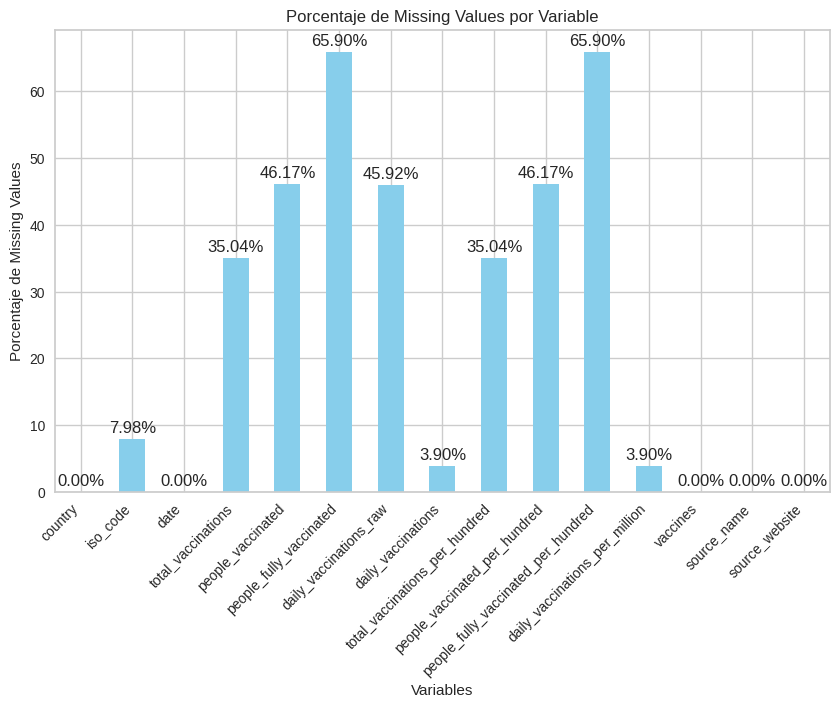

In [ ]:
# Resumen de variables y cantidad de NaNs
summary = df1_or.describe(include='all')
summary['missing_values'] = df1_or.isnull().sum()

# Mostrar el resumen
print(summary)
plot_missing_values(df1_or)

### 1.1

Ahora podemos abordar la problemática de los valores faltantes en la variable "people vaccinated". La estrategia para completar estos datos consiste en tomar los valores de los tres días anteriores (si están disponibles; de lo contrario, dos o uno) y calcular su media para llenar la celda correspondiente.

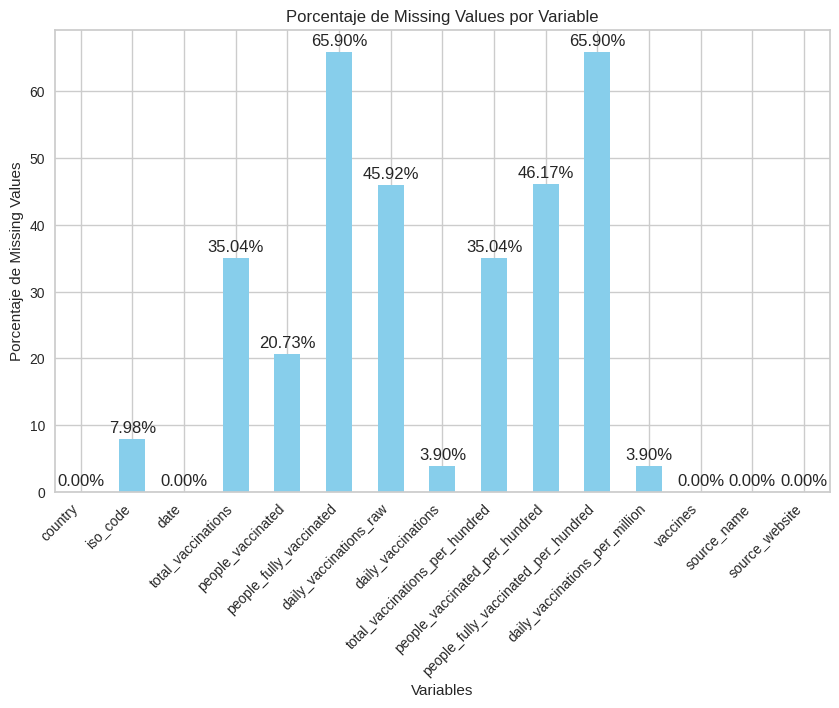

In [ ]:
# Ordena el DataFrame por país y fecha
df1.sort_values(by=['country', 'date'], inplace=True)

# Itera sobre el DataFrame para llenar los valores faltantes
for index, row in df1.iterrows():
    country = row['country']
    date = row['date']
    vaccinated = row['people_vaccinated']

    # Obtén los valores de los 3 días anteriores (o menos)
    previous_days = df1[(df1['country'] == country) & (df1['date'] < date)].tail(3)

    # Calcula la media de los valores disponibles
    mean_vaccinated = previous_days['people_vaccinated'].mean()

    # Llena el valor faltante con la media calculada
    if pd.isna(vaccinated):
        df1.at[index, 'people_vaccinated'] = mean_vaccinated

# Restablece el orden original del DataFrame
df1.sort_index(inplace=True)

# Visualización de los missing values del dataframe para ver si sirvió
plot_missing_values(df1)

Observamos que efectivamente se ha reducido significativamente el número de valores NaN en la variable objeto de estudio. No obstante, no se han eliminado por completo, y esto es comprensible. Si el país no había iniciado su proceso de vacunación hasta esa fecha, no habría registros de vacunación para ese día.

### 1.2


#### Preprocesado y análisis de calidad
Vamos a realizar una primera visualización temporal de las vacunas en un país específico, seleccionando Argentina como ejemplo. Esto nos permitirá tener una mejor perspectiva de la variable que estamos analizando.

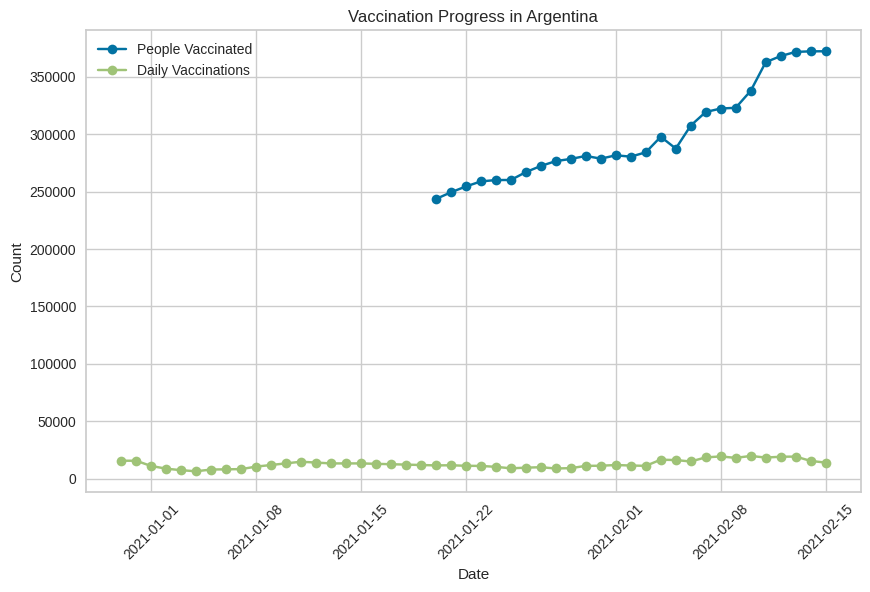

In [ ]:
# Filtrar los datos para el país Argentina
argentina_data = df1[df1['country'] == 'Argentina']

# Seleccionar solo las columnas 'date', 'people_vaccinated' y 'daily_vaccinations'
argentina_data = argentina_data[['date', 'people_vaccinated', 'daily_vaccinations']]

# Convertir la columna 'date' a formato de fecha
argentina_data['date'] = pd.to_datetime(argentina_data['date'])

# Ordenar el DataFrame por la columna 'date'
argentina_data.sort_values(by='date', inplace=True)

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar 'people_vaccinated' en el eje y
plt.plot(argentina_data['date'], argentina_data['people_vaccinated'], label='People Vaccinated', marker='o')

# Graficar 'daily_vaccinations' encima en el mismo gráfico
plt.plot(argentina_data['date'], argentina_data['daily_vaccinations'], label='Daily Vaccinations', marker='o')

# Configurar etiquetas y título
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Vaccination Progress in Argentina')
plt.legend()  # Mostrar leyenda

# Rotar las fechas en el eje x para mejorar la legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

Se ha identificado un problema al analizar los datos, ya que la variable seleccionada para el análisis de constancia probablemente no sea la más adecuada, dado que aparenta ser un acumulado de todas las vacunas administradas en el país hasta la fecha.

Propongamos la creación de una nueva variable que incluya el sumatorio de la variable "daily vaccinations", con el objetivo de verificar su coincidencia.

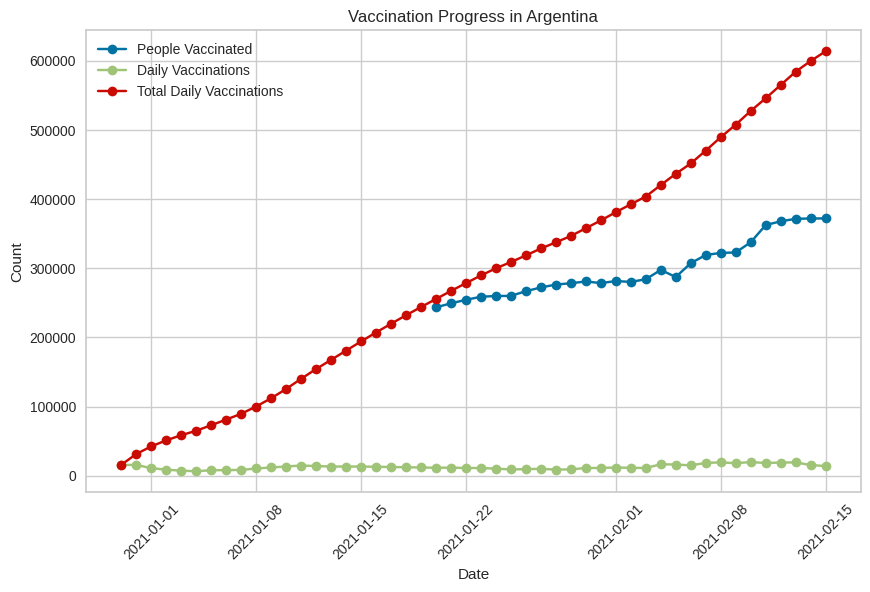

In [ ]:
# Crear una nueva columna 'total_daily_vaccinations' que acumula los datos de 'daily_vaccinations'
argentina_data['total_daily_vaccinations'] = argentina_data['daily_vaccinations'].cumsum()

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar 'people_vaccinated' en el eje y
plt.plot(argentina_data['date'], argentina_data['people_vaccinated'], label='People Vaccinated', marker='o')

# Graficar 'daily_vaccinations' encima en el mismo gráfico
plt.plot(argentina_data['date'], argentina_data['daily_vaccinations'], label='Daily Vaccinations', marker='o')

# Graficar 'total_daily_vaccinations' encima en el mismo gráfico
plt.plot(argentina_data['date'], argentina_data['total_daily_vaccinations'], label='Total Daily Vaccinations', marker='o')

# Configurar etiquetas y título
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Vaccination Progress in Argentina')
plt.legend()  # Mostrar leyenda

# Rotar las fechas en el eje x para mejorar la legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

Dado que previamente hemos modificado la variable "people vaccinated" y observamos que la suma de "daily vaccinations" prácticamente coincide con dicha variable, se sugiere que "people_vaccinated" representa un recuento acumulado de las vacunas administradas en el país hasta ese momento.

Sin embargo, al examinar el caso específico de Argentina, notamos que esta coincidencia no es exacta. Para confirmar la validez de esta hipótesis, procederemos a verificarla con otros países.

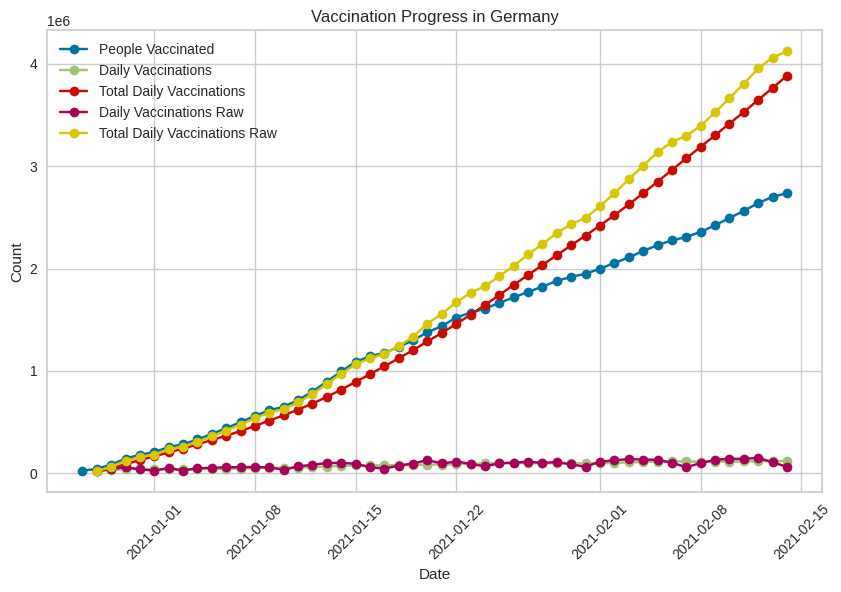

In [ ]:
# Filtrar los datos para el país Argentina
Germany_data = df1[df1['country'] == 'Germany']

# Seleccionar solo las columnas 'date', 'people_vaccinated', 'daily_vaccinations', daily_vaccinations_raw
Germany_data = Germany_data[['date', 'people_vaccinated', 'daily_vaccinations','daily_vaccinations_raw' ]]

# Convertir la columna 'date' a formato de fecha
Germany_data['date'] = pd.to_datetime(Germany_data['date'])

# Ordenar el DataFrame por la columna 'date'
Germany_data.sort_values(by='date', inplace=True)

# Crear una nueva columna 'total_daily_vaccinations' que acumula los datos de 'daily_vaccinations'
Germany_data['total_daily_vaccinations'] = Germany_data['daily_vaccinations'].cumsum()
Germany_data['total_daily_vaccinations_raw'] = Germany_data['daily_vaccinations_raw'].cumsum()

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar 'people_vaccinated' en el eje y
plt.plot(Germany_data['date'], Germany_data['people_vaccinated'], label='People Vaccinated', marker='o')

# Graficar 'daily_vaccinations' encima en el mismo gráfico
plt.plot(Germany_data['date'], Germany_data['daily_vaccinations'], label='Daily Vaccinations', marker='o')

# Graficar 'total_daily_vaccinations' encima en el mismo gráfico
plt.plot(Germany_data['date'], Germany_data['total_daily_vaccinations'], label='Total Daily Vaccinations', marker='o')

# Graficar 'daily_vaccinations_raw' encima en el mismo gráfico
plt.plot(Germany_data['date'], Germany_data['daily_vaccinations_raw'], label='Daily Vaccinations Raw', marker='o')

# Graficar 'total_daily_vaccinations_raw' encima en el mismo gráfico
plt.plot(Germany_data['date'], Germany_data['total_daily_vaccinations_raw'], label='Total Daily Vaccinations Raw', marker='o')

# Configurar etiquetas y título
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Vaccination Progress in Germany')
plt.legend()  # Mostrar leyenda

# Rotar las fechas en el eje x para mejorar la legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

Como se sospechaba previamente, la variable "people vaccinated" es un sumatorio, lo cual queda claramente evidenciado en el caso de Alemania, ya que este país no experimenta prácticamente ningún problema al registrar este dato. De hecho, Alemania no presenta ningún valor faltante (missing value) en esta variable.

Con nuestra hipótesis confirmada, es crucial explicar la discrepancia de valores a partir de la segunda semana. Esta diferencia podría atribuirse al hecho de que la variable "people vaccinated" cuenta la cantidad de personas en la población que están vacunadas, y esta población puede disminuir debido a diversos factores como defunciones, pérdida de efectividad de la vacuna, entre otros.

Otra razón para la disminución de la variable es que las segundas dosis para la misma persona se contabilizan en "daily vaccinations" pero no se suman nuevamente a la cantidad de personas vacunadas ("people vaccinated"). Sin embargo, dado que nuestro objetivo es calcular la constancia de la vacunación, podemos continuar el análisis siguiendo el mismo razonamiento.

Por lo tanto, procederemos a estudiar la cantidad de días que cada país ha llevado a cabo la vacunación utilizando las variables "daily vaccinations" y "daily vaccinations raw". Iniciaremos el análisis identificando los países que han demostrado una mayor constancia. Dado que la constancia es un indicador óptimo, el país con la menor variabilidad en la cantidad de vacunas diarias recibidas recibirá una mejor valoración.

Esto se traduce en que el país con la menor desviación estándar ha sido más constante en su estrategia de vacunación. Para llevar a cabo este estudio de manera efectiva, será necesario normalizar los datos.

Realicemos ahora lo mismo que en ejercicio 1.1 para eliminar los Nans de nuestra variable de estudio:

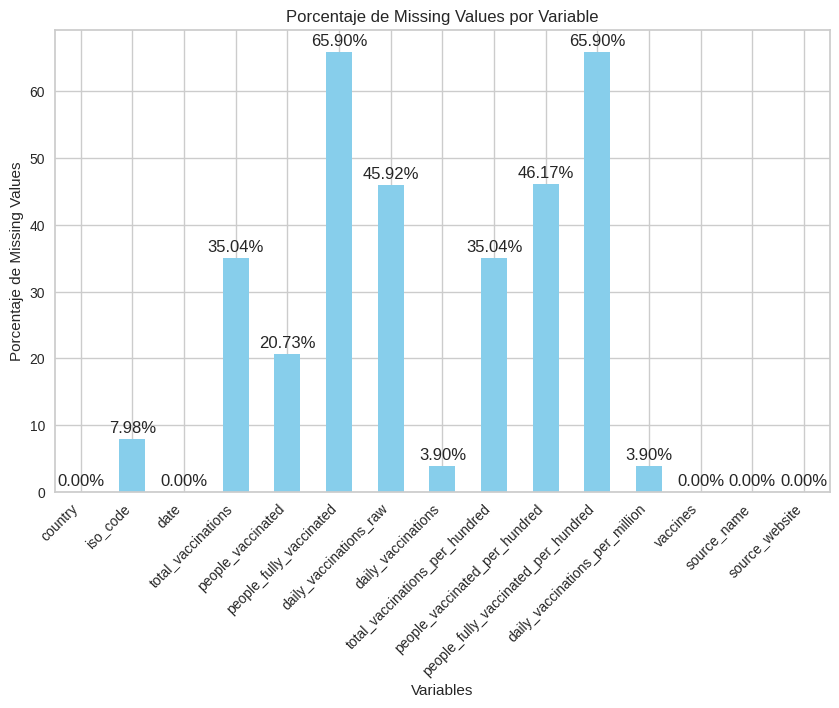

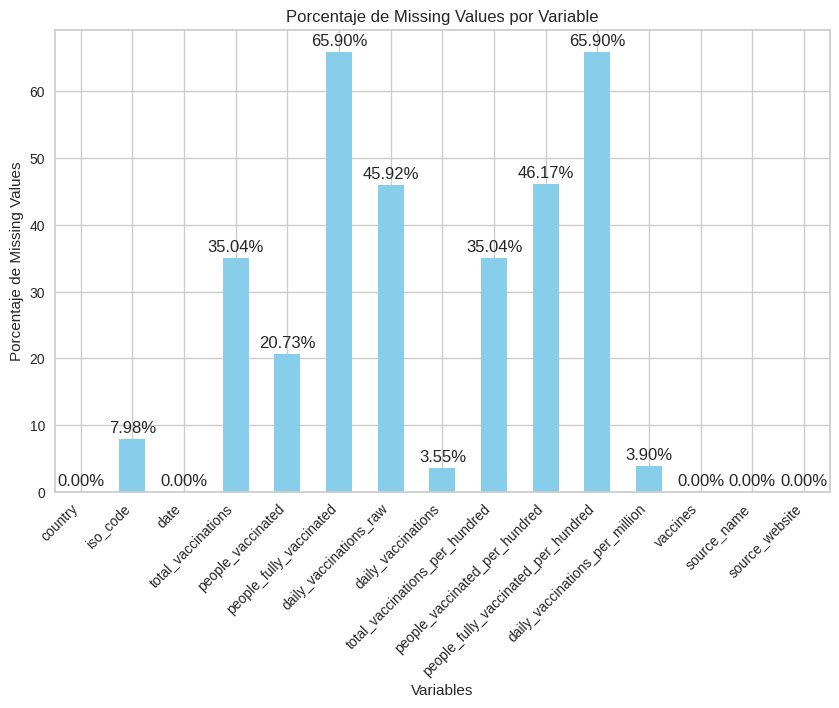

In [ ]:
plot_missing_values(df1)
# Ordena el DataFrame por país y fecha
df1.sort_values(by=['country', 'date'], inplace=True)

# Itera sobre el DataFrame para llenar los valores faltantes
for index, row in df1.iterrows():
    country = row['country']
    date = row['date']
    vaccinated = row['daily_vaccinations']

    # Obtén los valores de los 3 días anteriores (o menos)
    previous_days = df1[(df1['country'] == country) & (df1['date'] < date)].tail(3)

    # Calcula la media de los valores disponibles
    mean_vaccinated = previous_days['daily_vaccinations'].mean()

    # Llena el valor faltante con la media calculada
    if pd.isna(vaccinated):
        df1.at[index, 'daily_vaccinations'] = mean_vaccinated

# Restablece el orden original del DataFrame
df1.sort_index(inplace=True)

# Visualización de los missing values del dataframe para ver si sirvió
plot_missing_values(df1)

Recordemos que si no se han eliminado es porque no hay datos de vacunación en el país antes del primero. Esto es porque no habían comenzado las vacunaciones hasta días más tarde.

Sin embargo, no vamos a convertir los NaNs restantes a 0 por como vamos a analizar estas características.

#### Transformación de los datos

Ahora que hemos eliminado los valores NaN en "daily_vaccinations", estamos en condiciones de determinar qué país está implementando una estrategia de vacunación más efectiva. Con este propósito, procederemos a normalizar todos los datos de "daily_vaccinations" de todos los países en un rango de 0 a 1. Esto se logrará dividiendo cada dato por el máximo de vacunaciones registrado en cada país. La normalización se lleva a cabo con el fin de evaluar de manera equitativa la desviación estándar de cada país.

In [ ]:
df1_a = df1[['country', 'date', 'daily_vaccinations']] # Primero simplificamos nuestro dataframe.

# Dividir todos los datos de daily_vaccinations entre el máximo valor de daily_vaccinations de cada país
df1_a['daily_vaccinations_normalized'] = df1_a.groupby('country')['daily_vaccinations'].transform(lambda x: x / x.max())

<ipython-input-11-c99c179f16d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_a['daily_vaccinations_normalized'] = df1_a.groupby('country')['daily_vaccinations'].transform(lambda x: x / x.max())


Sin embargo, surge otro problema: algunos países, ya sea debido a la falta de transparencia en los datos o a su tamaño, presentan valores constantes en la variable "daily_vaccinations". En aras de la relevancia de nuestro estudio, hemos decidido eliminar dichos países de nuestro análisis. Esta elección se fundamenta en la consideración de que no resulta interesante comparar una colonia de ultramar de Inglaterra con un país de mayor envergadura, como Argentina. Además, ante la posibilidad de falta de transparencia en los datos, resulta difícil analizar la constancia de la estrategia de vacunación.

In [ ]:
# Filtramos los datos para excluir los valores iniciales que sean 0 o nan
# (queremos hacer el estudio una vez que se empiece a vacunar, no antes)
filtered_df1_a = df1_a[df1_a['daily_vaccinations_normalized'].notna() & (df1_a['daily_vaccinations_normalized'] != 0)]

# Calculamos la desviación típica por país
std_by_country = filtered_df1_a.groupby('country')['daily_vaccinations_normalized'].std()

# Creamos un nuevo dataframe con los países y la desviación típica
df1_b = pd.DataFrame({'country': std_by_country.index, 'std_deviation': std_by_country.values})


# AHORA FILTRAMOS LOS PAÍSES QUE NO QUEREMOS CALCULAR DENTRO DEL DATAFRAME

# Filtra los países con valor 0 o NaN en std_deviation
filtered_countries = df1_b[df1_b['std_deviation'].isnull() | (df1_b['std_deviation'] == 0)]

# Crea una lista con los nombres de los países
black_country_list = filtered_countries['country'].tolist()

# Imprime la lista de países
print("Países con valor 0 o NaN en std_deviation:")
print(black_country_list)

Países con valor 0 o NaN en std_deviation:
['Algeria', 'Anguilla', 'Azerbaijan', 'Cambodia', 'Egypt', 'Guernsey', 'Iran', 'Kuwait', 'Liechtenstein', 'Mauritius', 'Monaco', 'Pakistan', 'Qatar', 'Turks and Caicos Islands']


Ya tenemos nuestra "lista negra" de paises en los que no se puede realizar el análisis. Como posible equivocación de esta decisión cabe resaltar Mónaco, aunque, por su pequeño tamaño, es posible que la constancia absoluta de vacunas diarias sea cierta.

#### Aplicación de técnica analítica
Calculemos ahora los mejores países en constancia de vacunación (después de eliminar del dataframe los mencionados).

In [ ]:
# Filtra los registros que no están en la lista de países
df1_a = df1_a[~df1_a['country'].isin(black_country_list)]
df1_b = df1_b[~df1_b['country'].isin(black_country_list)]

# Ordena el dataframe por std_deviation de forma ascendente
df1_b = df1_b.sort_values(by='std_deviation', ascending=True)

# Selecciona los 10 primeros países con menor desviación estándar
top_countries = df1_b['country'].head(15).tolist()
print("Los 15 primeros países con menor desviación estándar (en orden):")
print(top_countries)

Los 15 primeros países con menor desviación estándar (en orden):
['Nepal', 'Northern Cyprus', 'Faeroe Islands', 'Spain', 'Cayman Islands', 'Malta', 'Jersey', 'Austria', 'Gibraltar', 'Peru', 'Oman', 'Argentina', 'Denmark', 'Croatia', 'Cyprus']


Ya tenemos en esa lista nuestra solución al problema, pero vayamos primero País por país para validar sus datos:

- Nepal: Los datos del Nepal parecen modificados o que tuvieron problemas a la hora de tomar el recuento debido a que del día 2021-01-27 al 2021-02-01 tienen exactamente el mismo número de vacunaciones diarias, por lo que este país estará descartado.

- Northern Cyprus: De nuevo los datos de Northern Cyprus parecen modificados o tuvieron problemas a la hora de tomar el recuento debido a que del día 2021-01-15 al 2021-01-19 tienen exactamente el mismo número de vacunaciones diarias, además, hay muy pocos registros de este país. Por lo que este país estará descartado.

- Faeroe Islands: De nuevo los datos de Faeroe Islands parecen modificados o, debido a su pequeño tamaño, del día 2021-01-29 al 2021-02-07 tienen exactamente el mismo número de vacunaciones diarias. Esto hace que no sea tan interesante para el estudio este país en concreto.

- Spain: España no tiene ninguna de las características que si que les pasó a los primeros países por lo que podremos considerarle como nuestro primer mejor país.

- Cayman Islands: De nuevo los datos de este país son constantes del 2020-12-27 al 2021-02-04, también hay que considerar que las islas caimán son una colonia británica de ultramar y ya estamos considerando a inglaterra en otro registro.

- Malta: Malta tiene buenos datos, y por lo tanto , si se puede considerar como nuestro segundo país que mas constante ha vacunado.

- Jersey: Esta isla es una dependencia de la corona británica que, es muy pequeña y tienen los mismos datos del día 2021-01-25 al 2021-01-31
por lo que se decide obviar este país.

- Austria: Austria tiene buenos datos, y por lo tanto, si se puede considerar como nuestro tercer país que más constante ha vacunado.

- Gibraltar: Dependientes de inglaterra, y sabiendo que ya se incluye en la base de datos inglaterra, se decide no considerar este territorio.

- Perú: Si bien es verdad que a este país le llegó la vacuna más tarde y por lo tanto no existen tantos datos en esta base de datos del país, si que se puede ver que en los pocos días de los que se tienen datos, el gobierno peruano vacunó de forma muy constante.

- Omán: Si bien es verdad que tienen una serie de días con el mismo número de vacunados, dado que hay muchos datos de este país, y que la media se aleja bastante de estos datos iguales, se decide considerar este país para la gráfica como el quinto país que vacunó de forma más constante.


Los países más constantes son por lo tanto: [Spain, Malta, Austria, Perú, Omán]

<ipython-input-14-ebf226c49c45>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_g['date'] = pd.to_datetime(df1_g['date'])


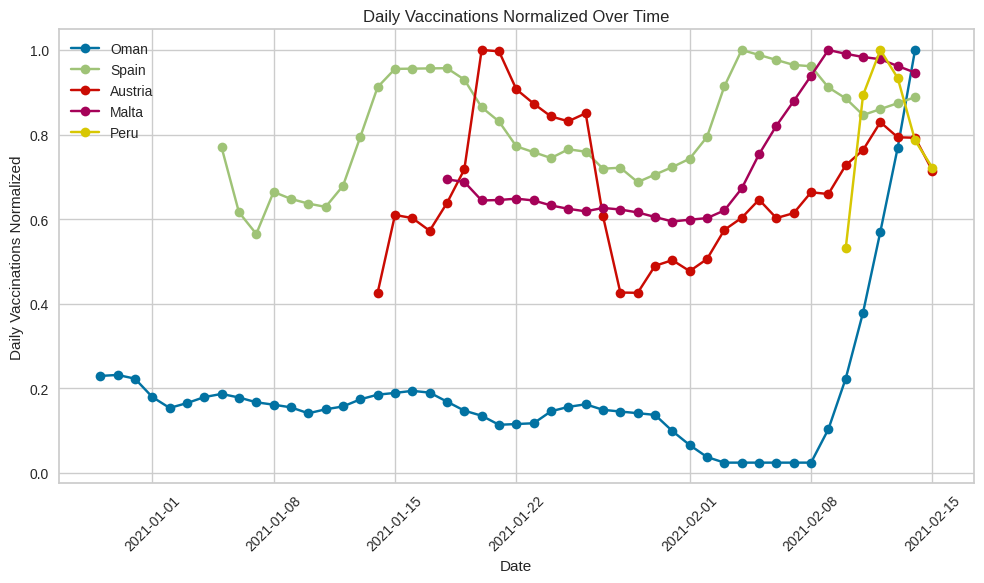

In [ ]:
paises_incluir = ['Spain', 'Malta', 'Austria', 'Peru', 'Oman']
df1_g = df1_a[df1_a['country'].isin(paises_incluir)]

# Convertir la columna 'date' a tipo datetime para asegurar el orden correcto
df1_g['date'] = pd.to_datetime(df1_g['date'])

# Ordenar el DataFrame por la columna 'date'
df1_g = df1_g.sort_values(by='date')

# Plot con leyenda
plt.figure(figsize=(10, 6))

# Iterar sobre los países únicos en el DataFrame
for country in df1_g['country'].unique():
    country_data = df1_g[df1_g['country'] == country]
    plt.plot(country_data['date'], country_data['daily_vaccinations_normalized'], marker='o', linestyle='-', label=country)

plt.title('Daily Vaccinations Normalized Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Vaccinations Normalized')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Práctica 2 (Sensores atmosféricos)

Se cuenta con los datos del año 2020 de distintas mediciones de un sensor medioambiental situado en el
campus de la Universidad Francisco de Vitoria. Para analizar la información recogida haremos uso de un
dataset proporcionado por la propia Universidad llamado “ozone”.


1.- (0,75 puntos) Llevar a cabo el estudio de los outliers de 3 variables (Wind_speed, Ozone_reading,
Visibility) de forma unidimensional. ¿Qué tipo de gráfico es necesario emplear? Interpretar los datos
obtenidos en cada caso.


2.- (0,75 puntos) Estudiar la intersección y la unión de outliers entre las variables “Wind_speed” y
“Visibility”.


3.- (1 punto) Categoriza algunas de las variables y lleva a cabo representaciones que nos permitan
relacionar diferentes variables ¿Qué nos dicen los datos?


4.- (1 punto) Se desea saber cómo se distribuyen y cuáles son las frecuencias de las principales variables
respecto a los días de medición. Lleva a cabo la representación más útil (sólo una). Justificar la respuesta.

Hagamos primero una pequeña exploración de los datos:

In [ ]:
# Seleccionar el archivo desde tu computadora
uploaded = files.upload()
# Cambiar el nombre del archivo según lo que hayas subido
file_name = "ozone.csv"

df2_or = pd.read_csv('ozone.csv', sep=',', header=None, skiprows=1)
# Especificar los nombres de las columnas manualmente si es necesario
nombres_columnas = ['Month', 'Day_of_month', 'Day_of_week', 'ozone_reading', 'pressure_height', 'Wind_speed',
                    'Humidity', 'Temperature_Sandburg', 'Temperature_ElMonte', 'Inversion_base_height',
                    'Pressure_gradient', 'Inversion_temperature', 'Visibility']

# Asignar los nombres de las columnas al DataFrame
df2_or.columns = nombres_columnas

# Mostrar las primeras filas del DataFrame
print(df2_or.head())

df2 = df2_or.copy() # Creamos otro dataframe para modificar y trabajar


print('\nPrimeras filas del DataFrame\n')
print(df2_or.head())

print('\nInformación general sobre el DataFrame\n')
print(df2_or.info())

print('\nEstadísticas descriptivas básicas\n')
print(df2_or.describe())

print('\nVerificar y manejar valores nulos\n')
print(df2_or.isnull().sum())

Saving ozone.csv to ozone.csv
   Month  Day_of_month  Day_of_week  ozone_reading  pressure_height  \
0      1             5            1           5.34             5760   
1      1             6            2           5.77             5720   
2      1             7            3           3.69             5790   
3      1             8            4           3.89             5790   
4      1             9            5           5.76             5700   

   Wind_speed  Humidity  Temperature_Sandburg  Temperature_ElMonte  \
0           3        51                    54                45.32   
1           4        69                    35                49.64   
2           6        19                    45                46.40   
3           3        25                    55                52.70   
4           3        73                    41                48.02   

   Inversion_base_height  Pressure_gradient  Inversion_temperature  Visibility  
0                   1450                 

No hay missing values por lo que se puede proceder a hacer el estudio deseado

### 2.1

Para llevar a cabo el estudio de los outliers de las tres variables (Wind_speed, Ozone_reading, Visibility) de manera unidimensional, se puede emplear un gráfico de caja, también conocido como diagrama de bigotes. Este tipo de representación visual proporciona una visión clara de la distribución de un conjunto de datos, facilitando la identificación de posibles valores atípicos.

Otra herramienta gráfica que puede ser utilizada para este análisis es el qqplot, el cual ayuda a determinar si los datos siguen una distribución específica y a identificar posibles desviaciones. Aunque es útil para diagnosticar la normalidad de los datos o evaluar cómo se ajustan a otras distribuciones estadísticas, en este caso hemos optado por el diagrama de bigotes ('boxplot'), ya que no estamos tratando de predecir aún el tipo de distribución que siguen nuestras variables.






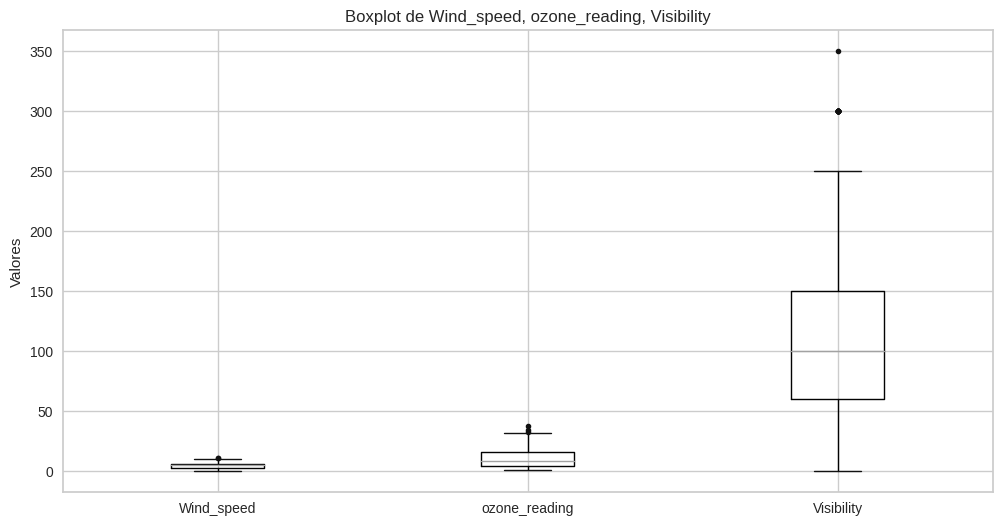

In [ ]:
# Seleccionar las columnas de interés
variables_of_interest = ['Wind_speed', 'ozone_reading', 'Visibility']
subset_df = df2[variables_of_interest]

# Crear un gráfico de caja para cada variable
plt.figure(figsize=(12, 6))
subset_df.boxplot(sym='k.', whis=1.5)
plt.title('Boxplot de Wind_speed, ozone_reading, Visibility')
plt.ylabel('Valores')
plt.show()

Vemos que efectivamente hay outliers, tanto en Wind_speed como en 'ozone_reading' y en Visibility

- 'Wind_speed': El máximo valor, 11, está lejos de la media (4.867) considerando la desviación típica (2.105) de esta distribución, por lo que se puede concluir que hay al menos 1 outlier en esta distribución

- 'ozone_reading': En ozone_reading se puede observar en la gráfica que hay al menos dos registros que pueden ser considerados como outliers.

- 'Visibility': La gráfica indica clareamente que existen 2 registros que son considerados outliers.

### 2.2

Para examinar la intersección y la unión de outliers entre las variables "Wind_speed" y "Visibility", procederemos a analizar los valores atípicos (outliers) de ambas variables y a evaluar la superposición o diferencia entre ellas.

La intersección de outliers hace referencia a los valores que son considerados outliers tanto en la variable "Wind_speed" como en "Visibility", es decir, aquellos registros que son identificados como outliers para ambas variables. Por otro lado, la unión de outliers comprendería todos los valores que son outliers en al menos una de las dos variables.

Para iniciar, examinaremos el boxplot de ambas variables.

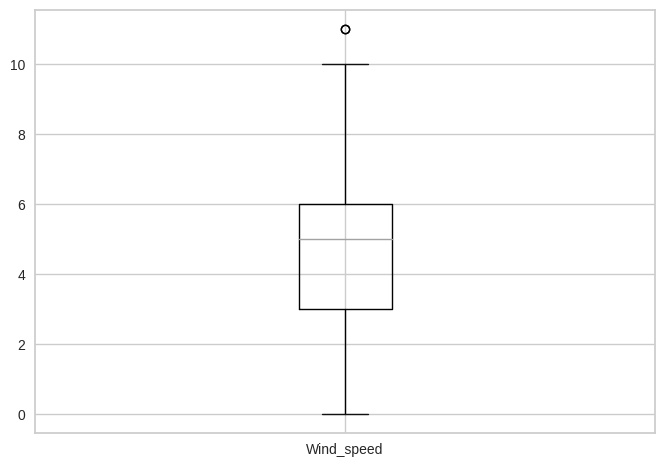

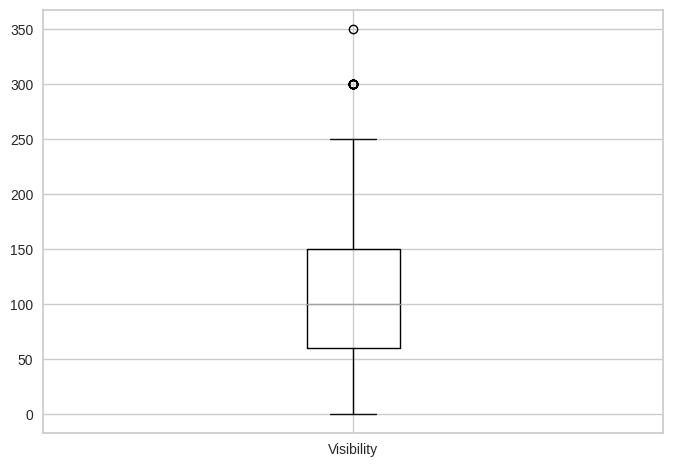

In [ ]:
# Seleccionar las variables de interés
selected_variables = ['Wind_speed', 'Visibility']
df2_WsV = df2[selected_variables]
df2_Ws = df2[['Wind_speed']]
df2_V = df2[['Visibility']]
# Visualizar la distribución de las variables
df2_Ws.boxplot()
plt.show()
df2_V.boxplot()
plt.show()

Identificación de la unión e intersección de los outliers:

In [ ]:
# Calcular los límites para los outliers (usamos los mismos límites que usa el boxplot)
lower_bound_ws = df2_WsV['Wind_speed'].quantile(0.25) - 1.5 * (df2_WsV['Wind_speed'].quantile(0.75) - df2_WsV['Wind_speed'].quantile(0.25))
upper_bound_ws = df2_WsV['Wind_speed'].quantile(0.75) + 1.5 * (df2_WsV['Wind_speed'].quantile(0.75) - df2_WsV['Wind_speed'].quantile(0.25))

lower_bound_vis = df2_WsV['Visibility'].quantile(0.25) - 1.5 * (df2_WsV['Visibility'].quantile(0.75) - df2_WsV['Visibility'].quantile(0.25))
upper_bound_vis = df2_WsV['Visibility'].quantile(0.75) + 1.5 * (df2_WsV['Visibility'].quantile(0.75) - df2_WsV['Visibility'].quantile(0.25))

# Filtrar los outliers para cada variable
df2_outliers_ws = df2_WsV[(df2_WsV['Wind_speed'] < lower_bound_ws) | (df2_WsV['Wind_speed'] > upper_bound_ws)]
df2_outliers_vis = df2_WsV[(df2_WsV['Visibility'] < lower_bound_vis) | (df2_WsV['Visibility'] > upper_bound_vis)]

# Calcular la intersección de los outliers
df2_outliers_intersection = pd.merge(df2_outliers_ws, df2_outliers_vis, how='inner')

# Calcular la unión de los outliers
df2_outliers_union = pd.merge(df2_outliers_ws, df2_outliers_vis, how='outer')

# Mostrar el nuevo DataFrame con la intersección de outliers
print('Los registros que son outliers en ambas variables a la vez son:')
print(df2_outliers_intersection)
print('\nLos registros que son outliers en alguna de las dos variables son:')
print(df2_outliers_union)


Los registros que son outliers en ambas variables a la vez son:
   Wind_speed  Visibility
0          11         350

Los registros que son outliers en alguna de las dos variables son:
    Wind_speed  Visibility
0           11         350
1           11         200
2           10         300
3            5         300
4            5         300
5            5         300
6            8         300
7            7         300
8            7         300
9            7         300
10           7         300
11           0         300
12           0         300
13           3         300
14           6         300
15           6         300
16           4         300
17           4         300


Como se puede observar en la unión e intersección, la presencia de un outlier en Wind_Speed implica la existencia de un outlier o, como mínimo, un valor alto en Visibility. Sin embargo, esta relación no se cumple en sentido contrario; es decir, la presencia de un outlier en Visibility no implica necesariamente la presencia de un outlier en Wind_speed.

Esta observación sugiere que, en términos de la interpretación literal de las variables, la existencia de fuertes vientos está asociada con una buena visibilidad, pero tener buena visibilidad no necesariamente implica la presencia de fuertes vientos.

### 2.3

 Categoriza algunas de las variables y lleva a cabo representaciones que nos permitan relacionar diferentes variables ¿Qué nos dicen los datos?

Procedamos primero a entender las variables de estudio para ver qué puede ser interesante observar.

| Variable               | Descripción                                      | Significado                                                   | Tipo de dato |
|------------------------|--------------------------------------------------|---------------------------------------------------------------|--------------|
| Month                  | Mes del año (1-12)                               | Indica la época del año en la que se recopilaron los datos.    | Numérico (fecha)      |
| Day_of_month           | Día del mes (1-31)                               | Indica el día específico del mes en que se recopilaron los datos.| Numérico (fecha)     |
| Day_of_week           | Día de la semana (1-7, donde 1 es lunes)         | Puede ser útil para analizar si hay patrones en los datos según el día de la semana. | Numérico (fecha)      |
| ozone_reading          | Lectura de ozono (en ppb)                        | Indica la concentración de ozono en la atmósfera.              | Numérico (continuo)    |
| pressure_height        | Altura de la presión (en metros)                | Indica la altura a la que se midió la presión atmosférica.     | Numérico (continuo)     |
| Wind_speed             | Velocidad del viento (en m/s)                   | Indica la velocidad del viento en el momento de la medición.  | Numérico (discretizado)     |
| Humidity               | Humedad (%)                                      | Indica la cantidad de vapor de agua en el aire.                | Numérico (continuo de 0 a 100)   |
| Temperature_Sandburg   | Temperatura en Sandburg (°F)                     | Indica la temperatura en la estación meteorológica de Sandburg.| Numérico    (continuo)  |
| Temperature_ElMonte    | Temperatura en El Monte (°F)                     | Indica la temperatura en la estación meteorológica de El Monte.| Numérico    (continuo)  |
| Inversion_base_height  | Altura de la base de la inversión (en metros)    | Indica la altura a la que se encuentra la base de la capa de inversión térmica. | Numérico  (continuo)    |
| Pressure_gradient      | Gradiente de presión (en mmHg/km)               | Indica la tasa de cambio de la presión atmosférica con la distancia. | Numérico   (continuo)   |
| Inversion_temperature  | Temperatura de la inversión (°F)                 | Indica la temperatura dentro de la capa de inversión térmica.  | Numérico     (continuo) |
| Visibility             | Visibilidad (en millas)                          | Indica la distancia a la que se pueden ver objetos con claridad.| Numérico   (discretizado) |


Las variables que vamos a categorizar serán las siguientes:

- Wind_speed: Esta variable como ya ha sido observada, podremos discretizarla y aun asi noi perder demnasiada información.
- Visibility: Por el mismo razonamiento que en la anterior y dado a que por como esta distribuida la variable en el dataset, estacategorización tiene sentido.

Más allá de esto, modificaremos las variables de fecha para después hacer un estudio temporal de las variables.

In [ ]:

# CATEGORIZACION

df2_hist = df2.copy()

# Convertir la variable Wind_speed a enteros
df2_hist['Wind_speed'] = df2_hist['Wind_speed'].astype('int')

# Categorizar la variable Wind_speed
df2_hist['Wind_speed_category'] = pd.cut(df2_hist['Wind_speed'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, np.inf], labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Más de 10'])

# Categorizar la variable Visibility
df2_hist['Visibility_category'] = pd.cut(df2_hist['Visibility'], bins=[-5, 5, 15, 25, 35, 45, 55, 65, 75, 85, 95, np.inf], labels=['-5 a 5', '6 a 15', '16 a 25', '26 a 35', '36 a 45', '46 a 55', '56 a 65', '66 a 75', '76 a 85', '86 a 95', 'Más de 95'])


# Agregar la columna 'Year' a las fechas faltantes
df2['Year'] = 2020

# Crear la columna 'Date' utilizando el formato YYYY-MM-DD
df2['Date'] = df2['Year'].astype(str) + '-' + df2['Month'].astype(str) + '-' + df2['Day_of_month'].astype(str)

# Convertir a datetime
df2['Date'] = pd.to_datetime(df2['Date'], errors='coerce')

# Dropeamos las variables de fecha menos las del dia de la semana para facilitar otros estudios:


# Mostrar el DataFrame
df2_hist.head()

,Month,Day_of_month,Day_of_week,ozone_reading,pressure_height,Wind_speed,Humidity,Temperature_Sandburg,Temperature_ElMonte,Inversion_base_height,Pressure_gradient,Inversion_temperature,Visibility,Wind_speed_category,Visibility_category
0,1,5,1,5.34,5760,3,51,54,45.32,1450,25,57.02,60,2,56 a 65
1,1,6,2,5.77,5720,4,69,35,49.64,1568,15,53.78,60,3,56 a 65
2,1,7,3,3.69,5790,6,19,45,46.40,2631,-33,54.14,100,5,Más de 95
3,1,8,4,3.89,5790,3,25,55,52.70,554,-28,64.76,250,2,Más de 95
4,1,9,5,5.76,5700,3,73,41,48.02,2083,23,52.52,120,2,Más de 95


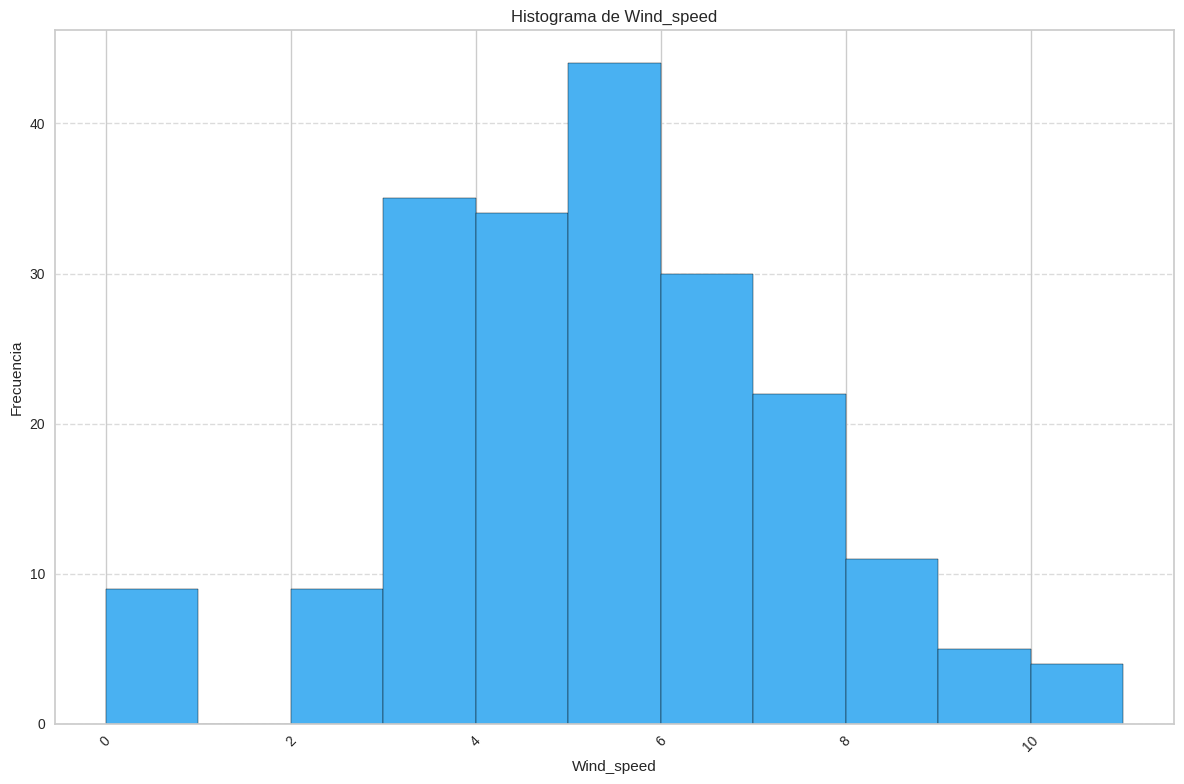

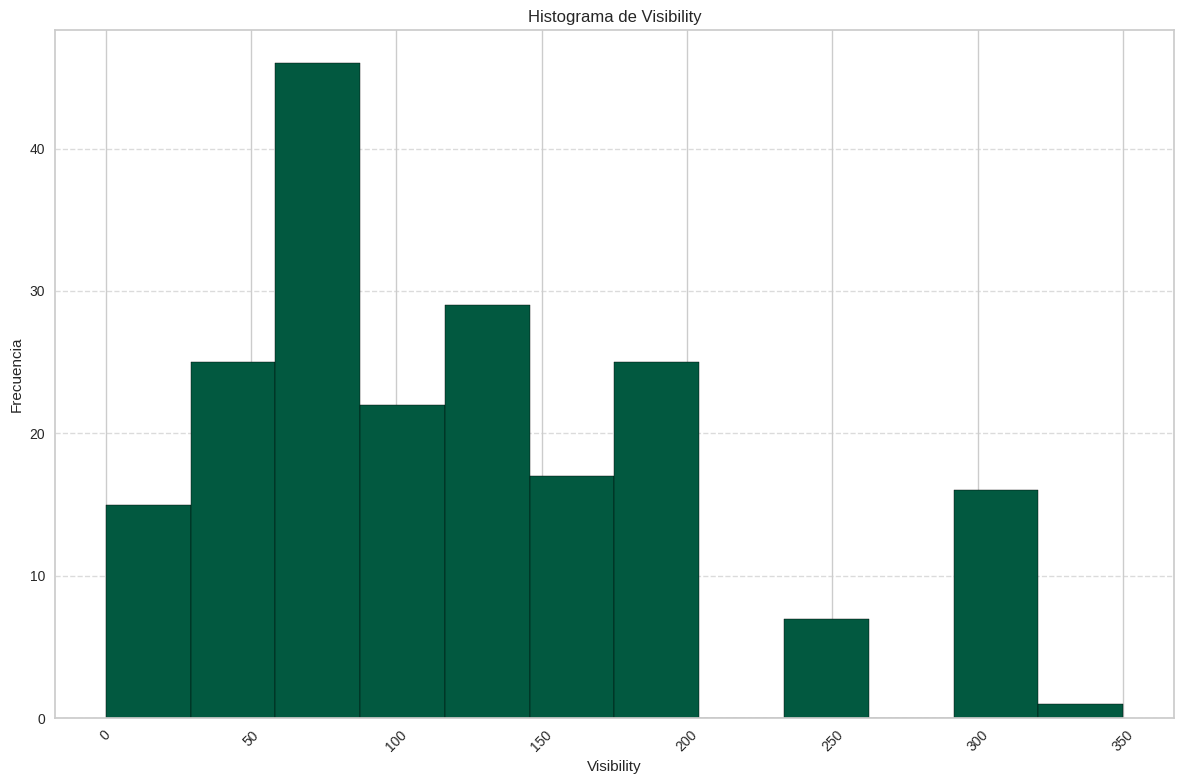

In [ ]:
# Categorizar Wind_speed y Visibility
df2_hist['Wind_speed'] = df2_hist['Wind_speed'].astype(int)  # Convierte a enteros


# Generar histograma de Wind_speed
plt.figure(figsize=(12, 8))
plt.hist(df2['Wind_speed'], bins='auto', color='#49B1F2', edgecolor='black')
plt.title('Histograma de Wind_speed')
plt.xlabel('Wind_speed')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejorar la legibilidad
plt.tight_layout()  # Ajustar el diseño para evitar recorte
plt.show()

# Generar histograma de Visibility
plt.figure(figsize=(12, 8))
plt.hist(df2['Visibility'], bins='auto', color='#025940', edgecolor='black')
plt.title('Histograma de Visibility')
plt.xlabel('Visibility')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejorar la legibilidad
plt.tight_layout()  # Ajustar el diseño para evitar recorte
plt.show()

Se puede observar que las variables se han discretizado correctamente gracias a los histogramas.

Ahora usaremos una matriz de correlaciones para ver que variables puede ser interesante plotear.

Matriz de Correlación:
                       ozone_reading  pressure_height  Wind_speed  Humidity  \
ozone_reading               1.000000         0.596127    0.081799  0.479471   
pressure_height             0.596127         1.000000   -0.231617  0.038691   
Wind_speed                  0.081799        -0.231617    1.000000  0.303563   
Humidity                    0.479471         0.038691    0.303563  1.000000   
Temperature_Sandburg        0.773352         0.806330    0.041222  0.331323   
Temperature_ElMonte         0.760020         0.896894   -0.069835  0.211586   
Inversion_base_height      -0.551962        -0.508912    0.128349 -0.247039   
Pressure_gradient           0.173918        -0.245490    0.373288  0.624335   
Inversion_temperature       0.717562         0.856421   -0.129599  0.191019   
Visibility                 -0.476291        -0.342727    0.045343 -0.457502   

                       Temperature_Sandburg  Temperature_ElMonte  \
ozone_reading                      0.77

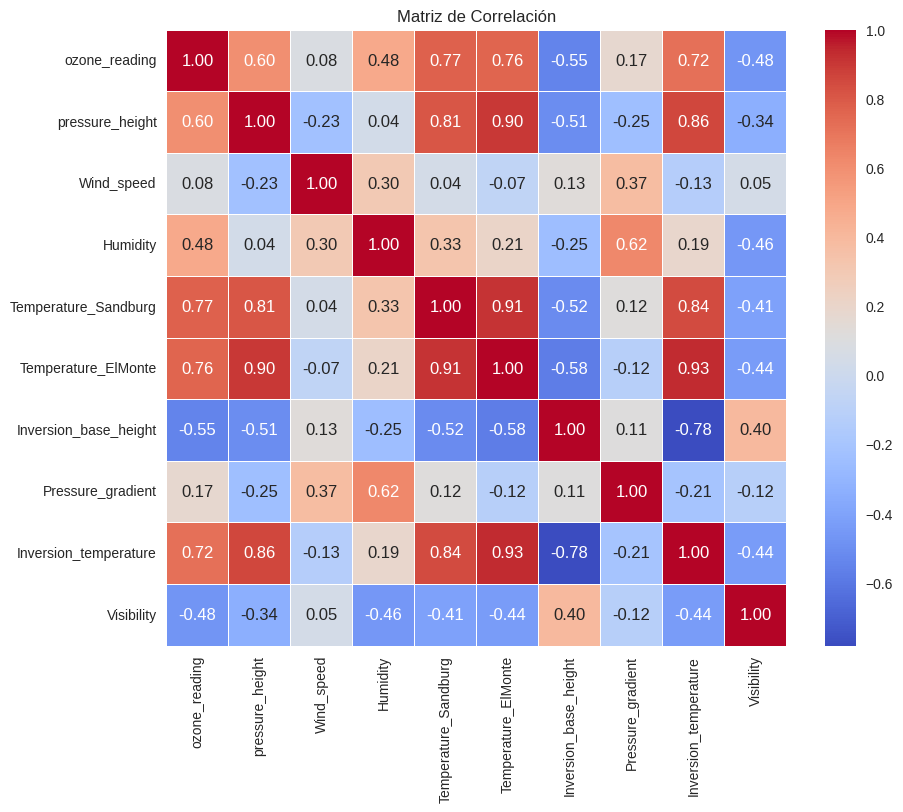

In [ ]:
# Eliminar las variables de fecha para la matriz de correlación
variables_no_fecha = df2.drop(['Month', 'Day_of_month', 'Day_of_week','Date','Year'], axis=1)

# Calcular la matriz de correlación
matriz_correlacion = variables_no_fecha.corr()

# Mostrar la matriz de correlación
print("Matriz de Correlación:")
print(matriz_correlacion)

# Crear un mapa de calor (heatmap) con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Matriz de Correlación")
plt.show()

Para visualizar como funcionan unas variables con otras, comparemos en el tiempo como evolucionan las variables de humidity con la variable de calor y ploteemos el resultado.

In [ ]:
# Modificaciones de informacion redundante dentro del dataframe
columns_to_drop = ['Month', 'Day_of_month', 'Year']
df2 = df2.drop(columns=columns_to_drop, errors='ignore')

# Cambiamos el orden de las variables.
column_order = ['Date', 'Day_of_week', 'ozone_reading', 'pressure_height', 'Wind_speed', 'Humidity',
                'Temperature_Sandburg', 'Temperature_ElMonte', 'Inversion_base_height', 'Pressure_gradient',
                'Inversion_temperature', 'Visibility']
df2 = df2[column_order]

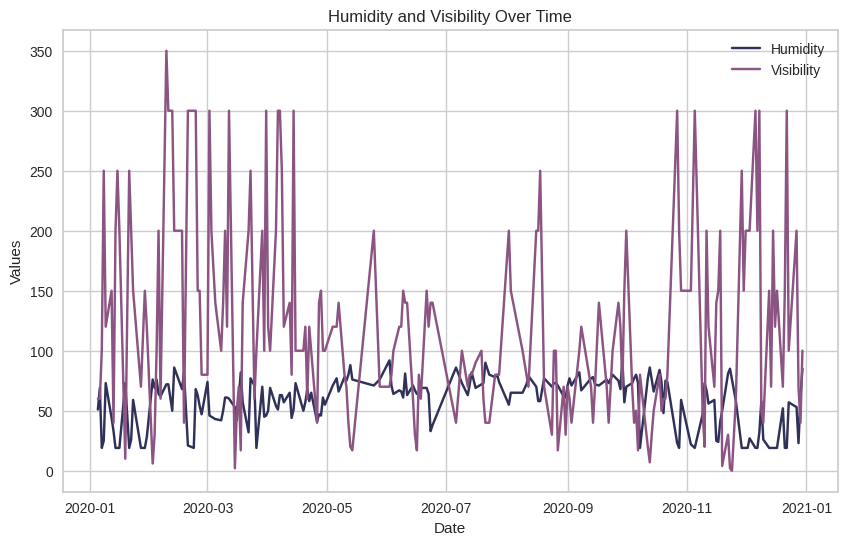

In [ ]:
# Convertir la columna 'Date' a tipo datetime
df2['Date'] = pd.to_datetime(df2['Date'])

# Ordenar el DataFrame por la columna 'Date'
df2 = df2.sort_values(by='Date')

# Trama de Humidity y Visibility a lo largo del tiempo
plt.figure(figsize=(10, 6))
plt.plot(df2['Date'], df2['Humidity'], color='#2F3159', label='Humidity')
plt.plot(df2['Date'], df2['Visibility'], color='#8C5483', label='Visibility')

# Configuración del gráfico
plt.title('Humidity and Visibility Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

Se puede observar tanto en la matriz de correlación como en la gráfica que estas dos variables están relacionadas de forma inversa, cuando una sube, la otra baja y viceversa. Tiene sentido ya que cuando hay más humedad, es normal que baje la visibilidad.

<ipython-input-24-450d37949829>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Date'] = pd.to_datetime(df_selected['Date'])


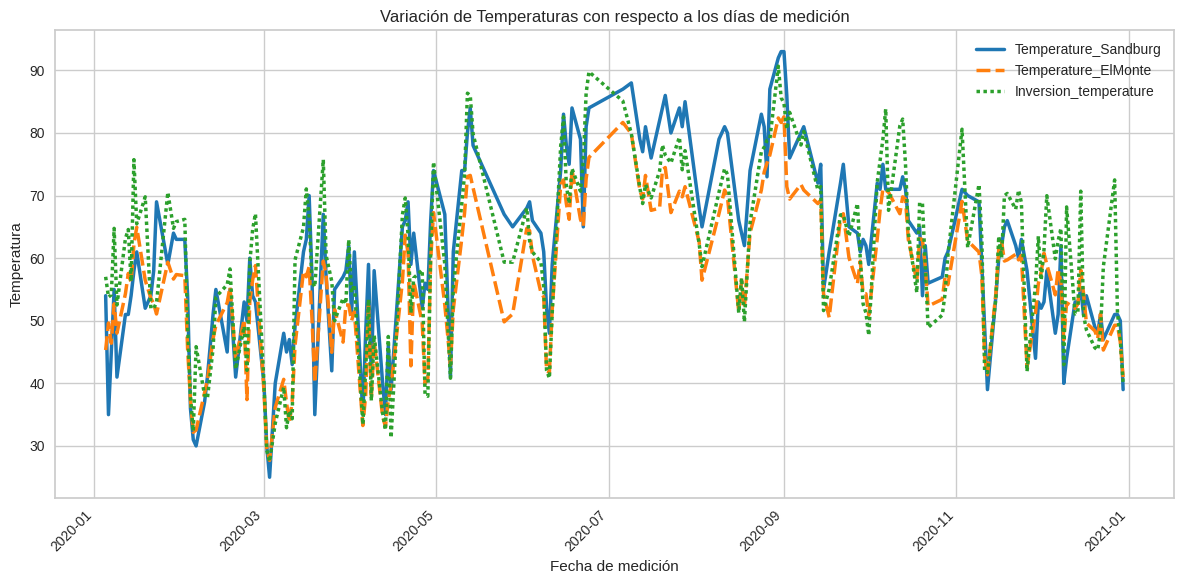

In [ ]:
# Selecciona las columnas relevantes para el análisis
columns_of_interest = ['Date', 'Temperature_Sandburg', 'Temperature_ElMonte', 'Inversion_temperature']

# Crea un nuevo DataFrame con las columnas seleccionadas
df_selected = df2[columns_of_interest]

# Convierte la columna 'Date' a tipo datetime si aún no lo está
df_selected['Date'] = pd.to_datetime(df_selected['Date'])

# Configura la fecha como índice para facilitar la visualización
df_selected.set_index('Date', inplace=True)

# Utiliza Seaborn para plotear las variables
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_selected, palette="tab10", linewidth=2.5)

# Añade etiquetas y título
plt.ylabel('Temperatura')
plt.xlabel('Fecha de medición')
plt.title('Variación de Temperaturas con respecto a los días de medición')

# Mejora el formato de las fechas en el eje x
plt.xticks(rotation=45, ha='right')

# Muestra el gráfico
plt.tight_layout()
plt.show()

### 2.4

Eligiremos la variable Ozone como la mas importante por estas razones:

- Impacto en la salud: La concentración de ozono en la atmósfera está directamente relacionada con la calidad del aire y puede tener un impacto significativo en la salud de las personas. Estudiar la variación de la lectura de ozono podría proporcionar información valiosa sobre la calidad del aire en el campus.

- Análisis temporal: Al considerar el mes, el día del mes y el día de la semana, podemos analizar patrones temporales en la concentración de ozono. Esto ayuda a identificar épocas del año o días específicos en los que la calidad del aire tiende a ser más crítica.

- Relaciones climáticas:  Existe relación entre la lectura de ozono y otras variables climáticas como temperatura, velocidad del viento, humedad, etc.,

Compararemos esta variable con la humedad ya que se sabe que las precipitaciones afectan a la calidad del aire

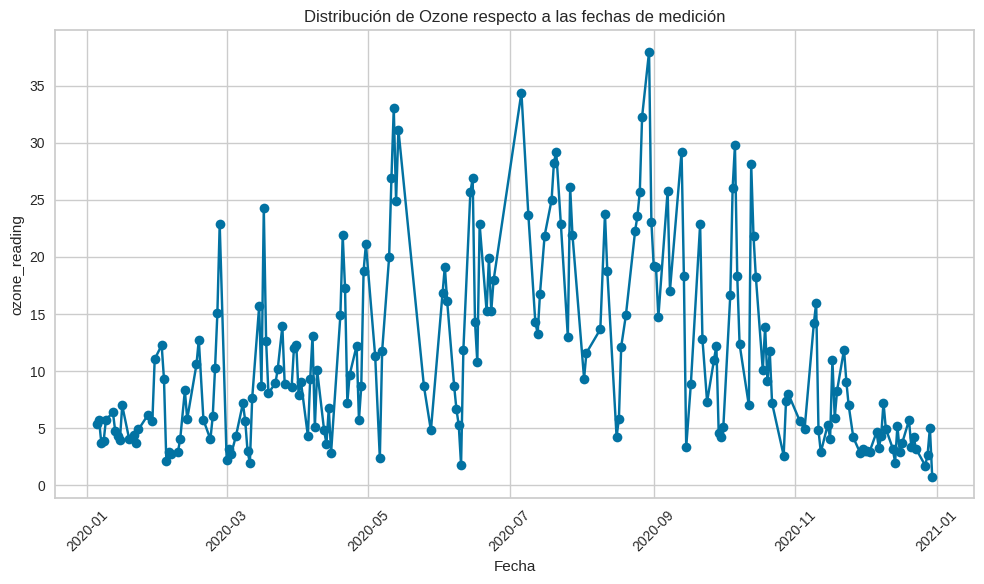

In [ ]:
# Plotear la variable Ozone con respecto a Date
plt.figure(figsize=(10, 6))
plt.plot(df2['Date'], df2['ozone_reading'], marker='o', linestyle='-', color='b')

# Configuraciones adicionales del gráfico
plt.title('Distribución de Ozone respecto a las fechas de medición')
plt.xlabel('Fecha')
plt.ylabel('ozone_reading')
plt.grid(True)
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## Práctica 3 (Reducción de la dimensionalidad)



PCA es una técnica utilizada para reducir la dimensionalidad de los datos al transformar el conjunto de variables originales en un nuevo conjunto de componentes principales, con el objetivo de conservar la mayor cantidad posible de información relevante mientras se simplifica la representación de los datos

Cargamos los datos almacenados en mi google drive desde un archivo en este caso excel.

Este ejercicio se resume en aplicar PCA por lo que resulta esencial importar la libreria PCA y vamos a cargar la libreria de kmeans para aplicar clusters al final para agrupar nuestras variables principales

Cargamos un archivo dataframe de pandas en Google Colab y mostrar las primeras filas del DataFrame cargado.

In [ ]:
from google.colab import files

# Seleccionar el archivo desde tu computadora
uploaded = files.upload()

# Leer el archivo usando pandas
import pandas as pd
import io

# Cambiar el nombre del archivo según lo que hayas subido
file_name = "USA.xlsx"

# Cargar el archivo en un DataFrame de pandas
df = pd.read_excel('USA.xlsx')
df = df.copy()

# Mostrar los datos
print(df.head())




Saving USA.xlsx to USA (2).xlsx
          Ciudad   SO2  Neg.Temp  Empresas  Poblacion  Viento  Precip   Dias
0        Phoenix  10.0      70.3     213.0      582.0     6.0    7.05   36.0
1    Little Rock  13.0      61.0      91.0      132.0     8.2   48.52  100.0
2  San Francisco  12.0      56.7     453.0      716.0     8.7   20.66   67.0
3         Denver  17.0      51.9     454.0      515.0     9.0   12.95   86.0
4       Hartford  56.0      49.1     412.0      158.0     9.0   43.37  127.0




Una vez que hemos cargado los datos vamos a proceder a la exploración inicial de los datos:


Vamos a realizar el analisis incial de la base de datos:
- En primer lugar, llama la atención que el valor máximo de SO2 sea 110, considerando que la media se sitúa alrededor de 30 y el 75% de los datos se encuentran en torno a 35. Esto podría indicar la presencia de valores atípicos que requerirían corrección.

- La media y la desviación estándar de la cantidad de empresas son relativamente altas, lo que sugiere una variabilidad significativa en la cantidad de empresas entre las ciudades analizadas.

*  La observación de 144 días con precipitación en este ejemplo podría llevarnos a conclusiones interesantes.
*  La cantidad de días en el análisis varía entre un mínimo de 36 días y un máximo de 166 días, indicando que algunas ciudades tienen datos recolectados durante un período más extenso que otras.


Es importante señalar que todas las variables presentadas son cuantitativas y numéricas. A continuación, mostramos las estadísticas descriptivas básicas, un paso fundamental en el análisis de datos para identificar posibles valores atípicos o comportamientos inusuales. Para facilitar la comprensión, cambiaré el nombre de la variable "Precip" a "Precipitación".


In [ ]:
#Valores atípicos de CO2:

Q1 = df['SO2'].quantile(0.25)
Q3 = df['SO2'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['SO2'] < (Q1 - 1.5 * IQR)) | (df['SO2'] > (Q3 + 1.5 * IQR))]
print("Valores atípicos en SO2:")
print(outliers)

# Calcular los percentiles 5 y 95 de la columna SO2
percentile_5 = df['SO2'].quantile(0.05)
percentile_95 = df['SO2'].quantile(0.95)

# Truncar los valores atípicos en la columna SO2
df['SO2'] = df['SO2'].clip(lower=percentile_5, upper=percentile_95)

# Verificar que los valores atípicos hayan sido corregidos
outliers_corrected = df[(df['SO2'] < percentile_5) | (df['SO2'] > percentile_95)]
print("Valores atípicos corregidos en SO2:")
print(outliers_corrected)

# Volver a calcular el resumen estadístico
print(df.describe())


Valores atípicos en SO2:
          Ciudad   SO2  Neg.Temp  Empresas  Poblacion  Viento  Precip   Dias
10       Chicago  69.0      50.6    3344.0     3369.0    10.4   34.44  122.0
28  Philadelphia  69.0      54.6    1692.0     1950.0     9.6   39.93  115.0
30    Providence  69.0      50.0     343.0      179.0    10.6   42.75  125.0
Valores atípicos corregidos en SO2:
Empty DataFrame
Columns: [Ciudad, SO2, Neg.Temp, Empresas, Poblacion, Viento, Precip, Dias]
Index: []
             SO2   Neg.Temp     Empresas    Poblacion     Viento     Precip  \
count  41.000000  41.000000    41.000000    41.000000  41.000000  41.000000   
mean   28.463415  55.763415   463.097561   608.609756   9.443902  36.769024   
std    19.002760   7.227716   563.473948   579.113023   1.428644  11.771550   
min     9.000000  43.500000    35.000000    71.000000   6.000000   7.050000   
25%    13.000000  50.600000   181.000000   299.000000   8.700000  30.960000   
50%    26.000000  54.600000   347.000000   515.000000  

Hemos corregido de forma significante la columna de C02, los hemos agrupado al percentil mas cercano (5,95)aplicando truncamiento.

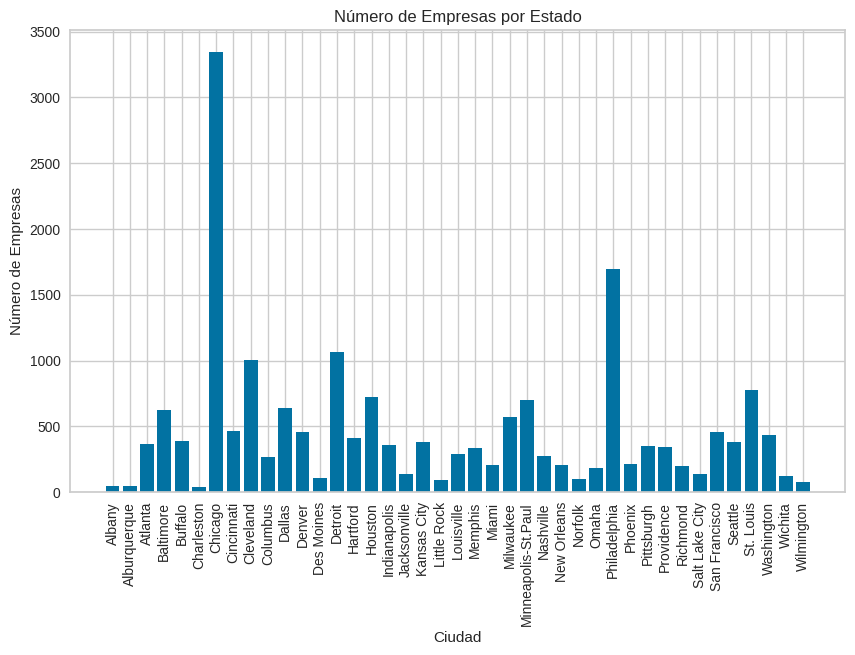

                 Ciudad  Variable  Correlacion_Empresas_Poblacion
0                Albany  Empresas                             NaN
1          Alburquerque  Empresas                             NaN
2               Atlanta  Empresas                             NaN
3             Baltimore  Empresas                             NaN
4               Buffalo  Empresas                             NaN
5            Charleston  Empresas                             NaN
6               Chicago  Empresas                             NaN
7            Cincinnati  Empresas                             NaN
8             Cleveland  Empresas                             NaN
9              Columbus  Empresas                             NaN
10               Dallas  Empresas                             NaN
11               Denver  Empresas                             NaN
12           Des Moines  Empresas                             NaN
13              Detroit  Empresas                             NaN
14        

In [ ]:


# Calcular el número total de empresas por estado
empresas_por_estado = df.groupby('Ciudad')['Empresas'].sum().reset_index()

# Visualizar el número de empresas por estado (diagrama de barras)
plt.figure(figsize=(10, 6))
plt.bar(empresas_por_estado['Ciudad'], empresas_por_estado['Empresas'])
plt.xlabel('Ciudad')
plt.ylabel('Número de Empresas')
plt.title('Número de Empresas por Estado')
plt.xticks(rotation=90)
plt.show()

# Calcular la correlación entre el número de empresas y otras variables
correlaciones = df.groupby('Ciudad')[['Empresas', 'Poblacion']].corr().iloc[0::2, -1].reset_index()
correlaciones.columns = ['Ciudad', 'Variable', 'Correlacion_Empresas_Poblacion']
print(correlaciones)


Vemos que Chicago es la ciudad que mas empresas tiene, tiene todo el sentido del mundo ya que es la 4ª ciudad mas poblada de EEUU.

In [ ]:
# Cambiar el nombre de la columna 'precip' a 'precio'
df = df.rename(columns={'Precip': 'Precio'})

# Mostrar los datos actualizados
print(df.head())

          Ciudad   SO2  Neg.Temp  Empresas  Poblacion  Viento  Precio   Dias
0        Phoenix  10.0      70.3     213.0      582.0     6.0    7.05   36.0
1    Little Rock  13.0      61.0      91.0      132.0     8.2   48.52  100.0
2  San Francisco  12.0      56.7     453.0      716.0     8.7   20.66   67.0
3         Denver  17.0      51.9     454.0      515.0     9.0   12.95   86.0
4       Hartford  56.0      49.1     412.0      158.0     9.0   43.37  127.0


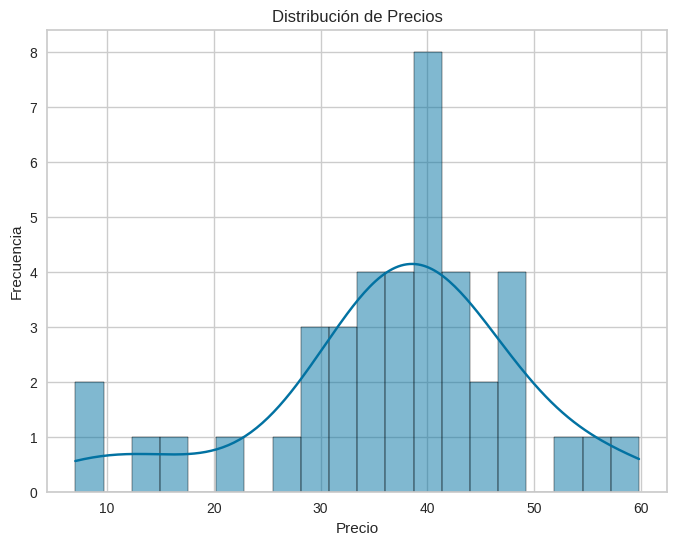

In [ ]:


# Visualización de histograma de la variable 'precio'
plt.figure(figsize=(8, 6))
sns.histplot(df['Precio'], bins=20, kde=True)
plt.title('Distribución de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()




limpieza de valores nulos:

In [ ]:
# Eliminar filas con valores nulos en cualquier columna
df_clean = df.dropna()

# Llenar los valores nulos con el promedio de la columna 'precio'
df['Precio'] = df['Precio'].fillna(df['Precio'].mean())


Vamos a utilizar el método de los cuartiles para tratar los outliers (procedimiento visto en Estadística )


In [ ]:
# Identificar los valores atípicos en la columna 'precio' usando el método de los cuartiles
Q1 = df['Precio'].quantile(0.25)
Q3 = df['Precio'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los valores atípicos
df_no_outliers = df[(df['Precio'] >= lower_bound) & (df['Precio'] <= upper_bound)]


Vamos a calcular los estadísticos descriptivos básicos:

In [ ]:
# Estadísticas descriptivas básicas de la columna 'precio'
precio_stats = df['Precio'].describe()
print(precio_stats)


count    41.000000
mean     36.769024
std      11.771550
min       7.050000
25%      30.960000
50%      38.740000
75%      43.110000
max      59.800000
Name: Precio, dtype: float64


Importamos todas las librerias y estandarizamos los datos:

In [ ]:
# Excluir columnas no numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns
X = df[numeric_columns]

# Estandarizar los datos
X_scaled = StandardScaler().fit_transform(X)
print(numeric_columns)
#Verificar si hay valores faltantes en el conjunto de datos y, si es necesario, tratarlos de manera adecuada


Index(['SO2', 'Neg.Temp', 'Empresas', 'Poblacion', 'Viento', 'Precio', 'Dias'], dtype='object')


Vamos a obtener los autovalores y los autovectores:

In [ ]:
# Paso 2: Obtener autovalores y autovectores
cov_matrix = np.cov(X.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Ordenar los autovalores y autovectores de mayor a menor
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Calcular el porcentaje de varianza explicada y el acumulado por cada componente
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
explained_variance_ratio_cumulative = np.cumsum(explained_variance_ratio)


# Crear DataFrame con los resultados
pca_results = pd.DataFrame({
    'Componente': np.arange(1, len(explained_variance_ratio) + 1),
    'Varianza Explicada': explained_variance_ratio,
    'Varianza Explicada Acumulada': explained_variance_ratio_cumulative
})

print("\nPorcentaje de varianza explicada por cada componente principal:")
print(pca_results)



Porcentaje de varianza explicada por cada componente principal:
   Componente  Varianza Explicada  Varianza Explicada Acumulada
0           1            0.975898                      0.975898
1           2            0.022566                      0.998464
2           3            0.001079                      0.999543
3           4            0.000266                      0.999809
4           5            0.000170                      0.999979
5           6            0.000019                      0.999998
6           7            0.000002                      1.000000


El objetivo principal es reducir la dimensionalidad de los datos mientras se conserva la mayor cantidad posible de información relevante, entonces utilizar solo la primera componente principal podría ser suficiente, ya que captura la gran mayoría de la varianza en los datos. (97,5%)


Información sobre las ciudades seleccionadas:
Ciudad       Cincinnati
SO2                23.0
Neg.Temp           54.0
Empresas          462.0
Poblacion         453.0
Viento              7.1
Precio            39.04
Dias              132.0
Name: 25, dtype: object
Ciudad       Salt Lake City
SO2                    28.0
Neg.Temp               51.0
Empresas              137.0
Poblacion             176.0
Viento                  8.7
Precio                15.17
Dias                   89.0
Name: 35, dtype: object
Ciudad       Pittsburgh
SO2                61.0
Neg.Temp           50.4
Empresas          347.0
Poblacion         520.0
Viento              9.4
Precio            36.22
Dias              147.0
Name: 29, dtype: object
Ciudad       Hartford
SO2              56.0
Neg.Temp         49.1
Empresas        412.0
Poblacion       158.0
Viento            9.0
Precio          43.37
Dias            127.0
Name: 4, dtype: object


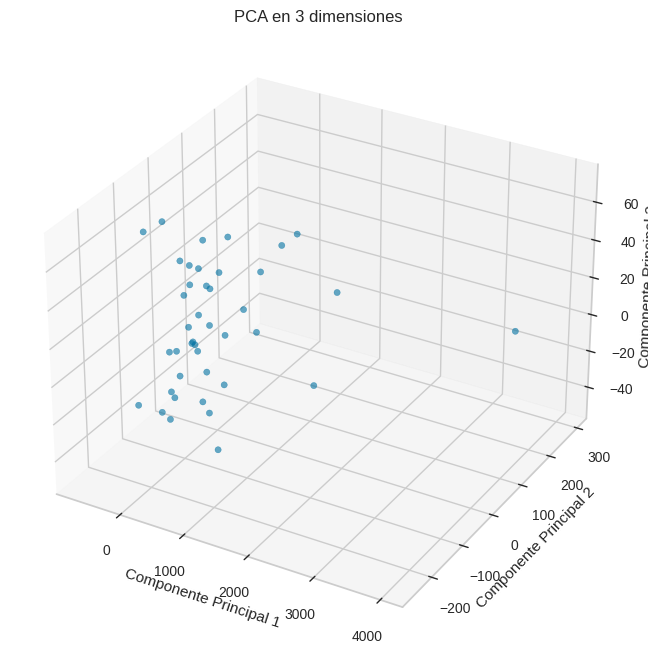

In [ ]:
# Paso 3: Obtener el diagrama de dispersión en 3 dimensiones
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], alpha=0.6)
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.set_title('PCA en 3 dimensiones')

# Elegir 4 ciudades al azar
np.random.seed(0)
random_cities = np.random.choice(df.index, size=4, replace=False)

# Imprimir información sobre las ciudades seleccionadas
print("\nInformación sobre las ciudades seleccionadas:")
for city in random_cities:
    print(df.loc[city])

plt.show()

Vamos a visualizar y escojer con cuantas variables nos quedamos:

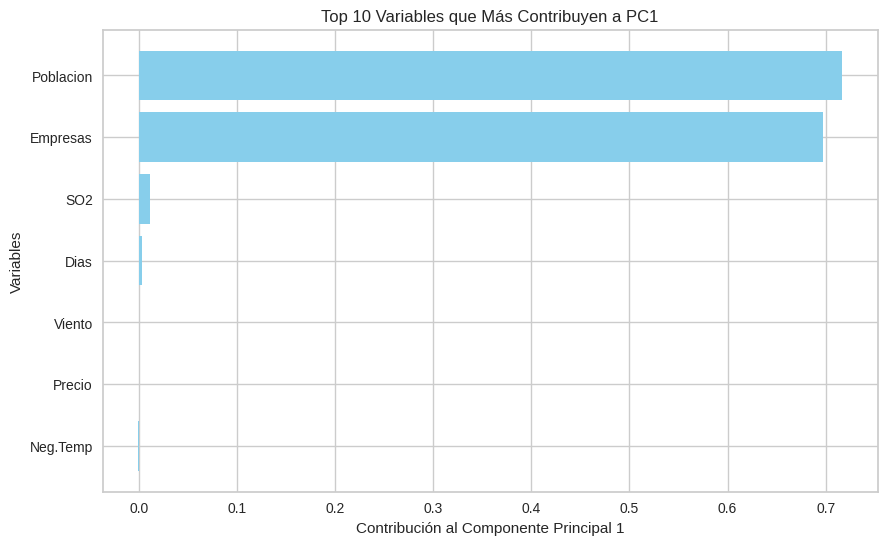

In [ ]:

# Realizar PCA
pca = PCA(n_components=3)  # Número de componentes principales a mantener
pca.fit(X)  # Ajustar el modelo de PCA a los datos

# Obtener los componentes principales
components = pca.components_

# Obtener las contribuciones de las variables al primer componente principal
top_variables_idx = np.argsort(components[0])[::-1][:10]  # Índices de las 10 variables con mayor contribución al PC1
top_variables = X.columns[top_variables_idx]  # Nombres de las variables
contributions = components[0][top_variables_idx]  # Contribuciones de las variables

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(top_variables, contributions, color='skyblue')
plt.xlabel('Contribución al Componente Principal 1')
plt.ylabel('Variables')
plt.title('Top 10 Variables que Más Contribuyen a PC1')
plt.gca().invert_yaxis()  # Invertir el eje y para que las variables más importantes estén en la parte superior
plt.show()



Veemos que tenemos cuatro variables significativas y dos que forman la maxima representación en cuanto a la correlación. En estadística hemos visto que todas las componentes por encima de 0.50 son significativas por lo tanto, nos quedamos con "población" y "empresas"

Vamos a realizar un scree- plot . Tendremosen el eje x  el número de componentes principales y en el eje y el porcentaje de varianza explicada por cada componente

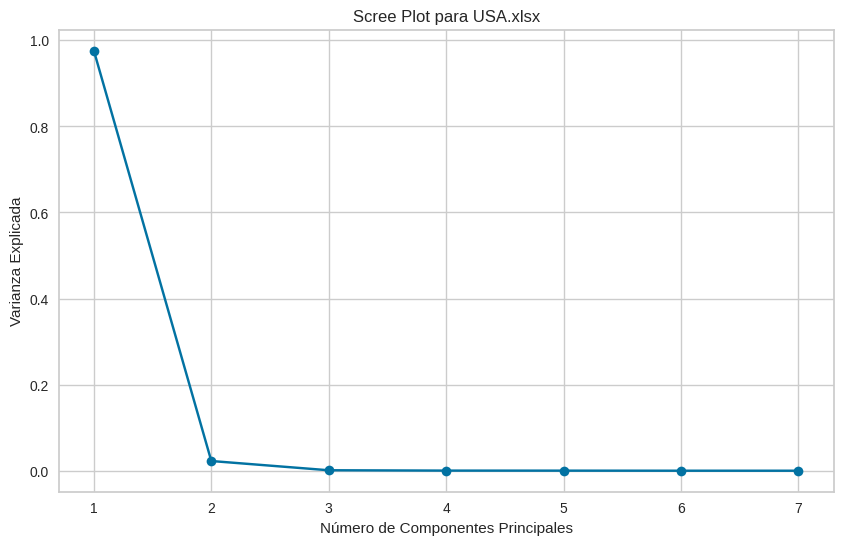

In [ ]:
# Crear el Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.title('Scree Plot para USA.xlsx')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

Podemos asegurar que las variables "Población" y "empresas" son las variables que mas correlación presentan y nos quedamos con dos variables.

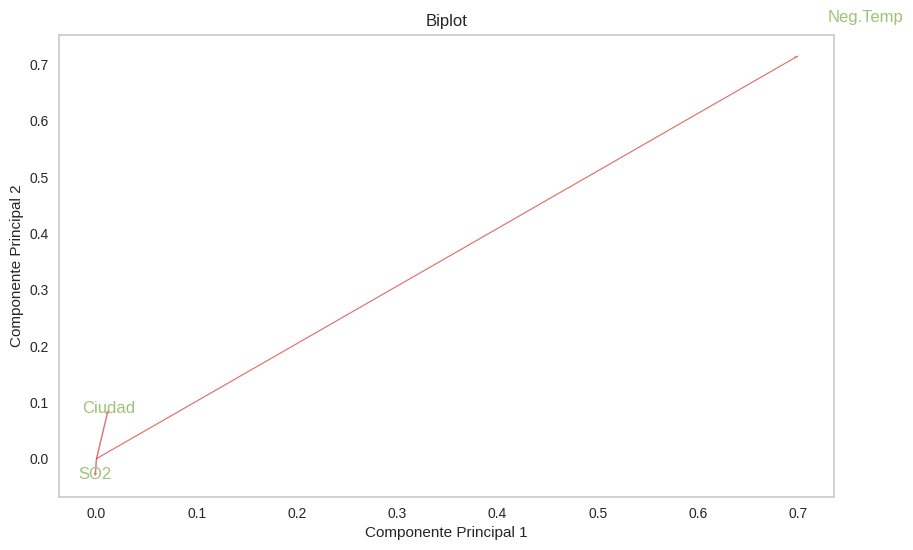

In [ ]:

# Cargar tus datos
NCI60 = pd.read_excel('USA.xlsx')

# Visualización del biplot
plt.figure(figsize=(10, 6))
for i in range(len(pca.components_)):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], color='r', alpha=0.5)
    plt.text(pca.components_[0, i]*1.1, pca.components_[1, i]*1.1, NCI60.columns[i], color='g', ha='center', va='center')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Biplot')
plt.grid()
plt.show()

La longitud del vector indica la importancia de esa variable en la dirección de la variabilidad representada por ese componente principal. Además, etiquetamos cada vector con el nombre de la variable correspondiente para facilitar la interpretación del biplot. En nuestro ejemplo, la variable C02 tiene suma importancia como vemos en el gráfico.

Se puede apreciar a la perfección con el "Scree plot" que nos podemos quedar unicamente con la primera variable y tendriamos el 97% de la varianza acumulada lo que es muy fiable, acompañado con que esa variable tiene mas del 70% de la varianza se podría tratar como la variable única

In [ ]:
# Crear la tabla con el porcentaje de varianza explicada
variance_explained_table = pd.DataFrame({
    'Número de Componentes': [1, 2, 3],
    'Varianza Explicada': [
        explained_variance_ratio_cumulative[0],  # Solo el primer componente
        explained_variance_ratio_cumulative[1],  # Primer y segundo componente
        explained_variance_ratio_cumulative[2]   # Primer, segundo y tercer componente
    ]
})

# Imprimir la tabla
print(variance_explained_table)


   Número de Componentes  Varianza Explicada
0                      1            0.975898
1                      2            0.998464
2                      3            0.999543


Vemos que añadir una o dos componentes mas no influye mucho mas al modelo y lo deja casi igual. Vamos a hacer Clustering con k-means para reducir de 2 dimensiones a 1 (que es lo mas eficiente como hemos visto con PCA)

In [ ]:
# Paso 3: Aplicar PCA
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

# Paso 4: Aplicar clustering (KMeans)
kmeans = KMeans(n_clusters=10)  # Elegir el número de clusters
clusters = kmeans.fit_predict(X_pca)

# Agregar los resultados de clustering al DataFrame original
df['Cluster'] = clusters

# Mostrar los resultados
print(df.head())

# Iterar sobre cada cluster
for cluster_id in range(10):
    # Filtrar el DataFrame para las filas que pertenecen a este cluster
    ciudades_en_cluster = df[df['Cluster'] == cluster_id]['Ciudad'].tolist()

    # Imprimir los nombres de las ciudades en este cluster
    print(f"Cluster {cluster_id}: {', '.join(ciudades_en_cluster)}")



          Ciudad   SO2  Neg.Temp  Empresas  Poblacion  Viento  Precio   Dias  \
0        Phoenix  10.0      70.3     213.0      582.0     6.0    7.05   36.0   
1    Little Rock  13.0      61.0      91.0      132.0     8.2   48.52  100.0   
2  San Francisco  12.0      56.7     453.0      716.0     8.7   20.66   67.0   
3         Denver  17.0      51.9     454.0      515.0     9.0   12.95   86.0   
4       Hartford  56.0      49.1     412.0      158.0     9.0   43.37  127.0   

   Cluster  
0        7  
1        4  
2        0  
3        8  
4        2  
Cluster 0: San Francisco, Wichita, Memphis, Nashville, Dallas, Salt Lake City, Richmond, Charleston
Cluster 1: Philadelphia
Cluster 2: Hartford, Baltimore, St. Louis, Buffalo, Seattle, Milwaukee
Cluster 3: Chicago
Cluster 4: Little Rock, Jacksonville, Miami, New Orleans, Alburquerque
Cluster 5: Washington, Indianapolis, Louisville, Albany, Columbus, Houston
Cluster 6: Detroit, Cleveland
Cluster 7: Phoenix
Cluster 8: Denver, Wilmington, A

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Es evidente que Chicago, al ser la ciudad con la población más grande (como se muestra en el diagrama de barras superior), ha sido agrupada en un único cluster, al igual que Philadelphia, que es la segunda ciudad con mayor población. También se observa que Detroit y Cleveland, al ocupar los siguientes lugares en población, han sido agrupadas en otro cluster. De esta manera, estamos aplicando el algoritmo K-Means en función de la población de las ciudades.

Vamos a ver la correlación de las ciudades dek cluster 9 por ejemplo. Vamos a calcular las correlaciones en dicho cluster y vamos a hacer un contraste de hipótesis para verificar nuestra conclusión:

In [ ]:


# Paso 1: Filtrar el DataFrame para las filas que pertenecen al cluster 9
cluster_9_data = df[df['Cluster'] == 9]

# Paso 2: Calcular la matriz de correlación para las variables en el cluster 9
correlation_matrix = cluster_9_data.corr()

# Paso 3: Imprimir la matriz de correlación
print("Matriz de correlación en el cluster 9:")
print(correlation_matrix)

# Paso 4: Realizar un contraste de hipótesis para verificar si la correlación es significativa
# Por ejemplo, podemos usar el coeficiente de correlación de Pearson y realizar una prueba de hipótesis de dos colas
alpha = 0.05  # Nivel de significancia

# Iterar sobre cada par de variables en la matriz de correlación
for var1 in correlation_matrix.columns:
    for var2 in correlation_matrix.columns:
        if var1 != var2:  # Evitar calcular la correlación de una variable consigo misma
            correlation, p_value = pearsonr(cluster_9_data[var1], cluster_9_data[var2])
            if p_value < alpha:
                print(f"Correlación significativa entre '{var1}' y '{var2}' en el cluster 9: {correlation:.2f}, p-value: {p_value:.4f}")


Matriz de correlación en el cluster 9:
                SO2  Neg.Temp  Empresas  Poblacion    Viento    Precio  \
SO2        1.000000  0.970913 -0.983783  -0.899372 -0.327327  0.978983   
Neg.Temp   0.970913  1.000000 -0.998113  -0.768535 -0.544049  0.901677   
Empresas  -0.983783 -0.998113  1.000000   0.806371  0.491502 -0.926527   
Poblacion -0.899372 -0.768535  0.806371   1.000000 -0.118712 -0.969630   
Viento    -0.327327 -0.544049  0.491502  -0.118712  1.000000 -0.127741   
Precio     0.978983  0.901677 -0.926527  -0.969630 -0.127741  1.000000   
Dias      -0.240192 -0.000781  0.062183   0.640408 -0.838628 -0.433115   
Cluster         NaN       NaN       NaN        NaN       NaN       NaN   

               Dias  Cluster  
SO2       -0.240192      NaN  
Neg.Temp  -0.000781      NaN  
Empresas   0.062183      NaN  
Poblacion  0.640408      NaN  
Viento    -0.838628      NaN  
Precio    -0.433115      NaN  
Dias       1.000000      NaN  
Cluster         NaN      NaN  
Correlación sig

<ipython-input-29-c32a34b379ae>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = cluster_9_data.corr()
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Podemos ver con facilidad que con una correlación del 97% y un p- valor de 0.0001 nos da una relación directa entre la población y las empresas por lo que podemos concluir con firmeza que la ciudad de Michigan al tener una población extensa tendrá a la vez muchas empresas para satisfacer toda la demanda requerida como bien intuiamos al inicio del ejercicio.

Tambien tiene mucho sentido la relación inversa de correlación entre la población y el C02 ya que a cuanta mayor población peor aire hay y por ello nos arroja esos resultados



<ipython-input-30-b3a7f3977c46>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlacion_ciudades = ciudades_cluster_9_data.corr()


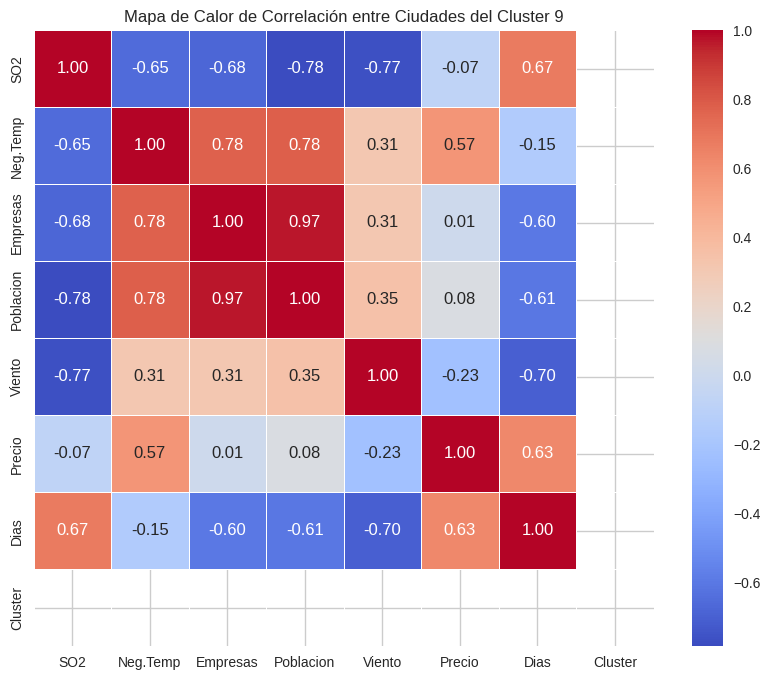

In [ ]:


# Ciudades del cluster 9
ciudades_cluster_9 = ['San Francisco', 'Wichita', 'Memphis', 'Nashville', 'Dallas', 'Salt Lake City', 'Richmond', 'Charleston']

# Seleccionar solo las filas del DataFrame original que corresponden a estas ciudades
ciudades_cluster_9_data = df[df['Ciudad'].isin(ciudades_cluster_9)]

# Calcular la matriz de correlación para estas ciudades
correlacion_ciudades = ciudades_cluster_9_data.corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion_ciudades, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Mapa de Calor de Correlación entre Ciudades del Cluster 9")
plt.show()



Podemos apreciar que los colores mas oscuros nos ofrecen la maxima correlación entre las variables. De forma inversa, los colores mas claros nos ofrecen una correlación inversa.